In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime
from datetime import timedelta, date
from dateutil.parser import parse
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import desc


In [2]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [3]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

# Reflect Tables into SQLAlchemy ORM

In [4]:
Base.classes.keys()

['measurement', 'station']

In [5]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [6]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [7]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
'''
DATEADD(year,-1,GETDATE()) or getdate() and dateadd(m,-12,getdate()
or WHERE date <  dateadd(m,-12,'2017-08-23 00:00:00') but not NS64 
would normally be the best choice but the database is not live
''' 
year_query = " SELECT * FROM measurement WHERE date >= '2016-08-23'"
year_df = pd.read_sql(year_query,conn)
year_df2 = year_df[['date','prcp']].copy()
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
year_df2.index = pd.to_datetime(year_df2.index) 
year_df2 = year_df2.set_index('date')

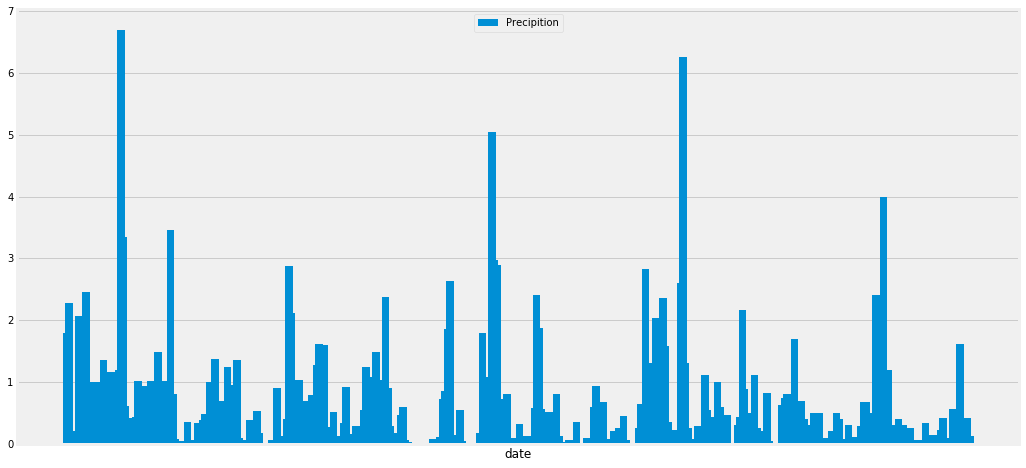

In [8]:
plt.figure(figsize=(16,8))
plt.bar(x=year_df2.index,
        height=year_df2['prcp'],
       width=3)
plt.legend(labels = ['Precipition'],loc=9)
plt.xticks([])
plt.xlabel('date')
plt.show()

In [9]:
# Use Pandas to calcualte the summary statistics for the precipitation data
stat_df = year_df.rename(columns={'prcp' : 'precipition'})

stat_df['precipition'].describe() 


count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipition, dtype: float64

In [10]:
# Design a query to show how many stations are available in this dataset?
Base.classes.keys()
Measurement = Base.classes.measurement
Station = Base.classes.station
session.query(Station).count()

9

In [11]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.prcp)).group_by(Measurement.station).\
order_by(desc(func.count(Measurement.prcp))).all()

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [12]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_id = session.query(Measurement.station, func.count(Measurement.prcp)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).limit(1).all()[0][0]
session.query(Measurement.station, func.min(Measurement.prcp),func.max(Measurement.prcp), func.avg(Measurement.prcp)).group_by(Measurement.station).filter_by(station=most_active_id).all()


[('USC00519281', 0.0, 9.64, 0.2123520923520915)]

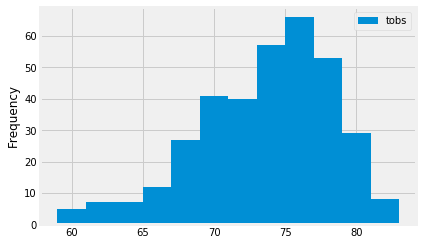

In [13]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_observation_query = "SELECT * FROM measurement WHERE date >= '2016-08-23'"
temp_obs_df = pd.read_sql(temp_observation_query,conn)
clean_df = temp_obs_df[temp_obs_df['station'] == most_active_id] 
clean_df['tobs'].plot.hist(legend=True,bins=12);

In [14]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()


In [15]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_df = pd.DataFrame(calc_temps('2017-02-28', '2017-03-05'),columns=['minimum', 'average', 'maximum'])
trip_df

,minimum,average,maximum
0,64.0,72.027778,78.0


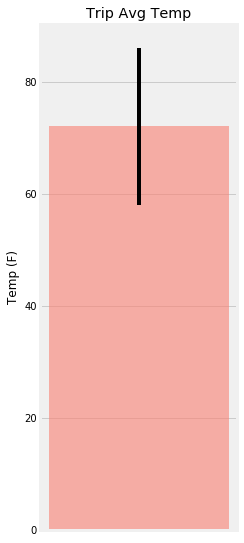

In [16]:
fig, ax = plt.subplots()

err = trip_df['minimum']-trip_df['maximum']

weather_bar = ax.bar(1,
                     trip_df['average'],
                     yerr=err,
                    color='#fa8072',
                    alpha=.6)
ax.grid(axis='x')

fig.tight_layout()
fig.set_size_inches(3,8)

plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.xticks([])
plt.show();

In [17]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session.query(Station.name ,Measurement.station,func.sum(Measurement.prcp)).\
filter(Station.station == Measurement.station).\
filter(Measurement.date >= '2017-02-28').\
filter(Measurement.date <='2017-03-05').\
group_by(Measurement.station,Station.name).\
order_by(func.sum(Measurement.prcp).desc()).all()


[('WAIHEE 837.5, HI US', 'USC00519281', 4.720000000000001),
 ('KANEOHE 838.1, HI US', 'USC00513117', 4.45),
 ('MANOA LYON ARBO 785.2, HI US', 'USC00516128', 4.07),
 ('PEARL CITY, HI US', 'USC00517948', 2.98),
 ('WAIKIKI 717.2, HI US', 'USC00519397', 2.7399999999999998),
 ('WAIMANALO EXPERIMENTAL FARM, HI US', 'USC00519523', 2.32),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US', 'USC00514830', 1.1600000000000001)]

## Optional Challenge Assignment

In [18]:
start = '2017-02-28'
end = '2017-03-05'

start_date = datetime.strptime(start, '%Y-%m-%d')
end_date = datetime.strptime(end, '%Y-%m-%d')


def daily_normals(date):    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)
        
date_list= []    
for single_date in daterange(start_date, end_date):
    date_list.append(single_date.strftime("%m-%d"))

normals = []
for x in date_list:
    normals.append(daily_normals(x)[0])
    
date_list

['02-28', '03-01', '03-02', '03-03', '03-04']

In [19]:
ser = pd.Series(normals)
extra_df = pd.DataFrame(ser)
it = extra_df[0]
normals[0]

(65.0, 70.65517241379311, 80.0)

In [20]:
min_temp = []
mean_temp = []
max_temp = []

for x,row in extra_df.itertuples():
    min_temp.append(it[x][0])
    mean_temp.append(it[x][1])
    max_temp.append(it[x][2])

In [21]:
# This matches the example but I don't like this because it makes it will be dated to 2018
# This also makes it seem like the future when this is really just a maybe
# date_list
# pd.to_datetime(date_list,format='%m-%d')
wrong_list = []
for date in date_list:
    wrong_list.append(date+'-'+'2018')
wrong_list
pd.to_datetime(wrong_list,format='%m-%d-%Y')

DatetimeIndex(['2018-02-28', '2018-03-01', '2018-03-02', '2018-03-03',
               '2018-03-04'],
              dtype='datetime64[ns]', freq=None)

In [22]:
transposed_df = pd.DataFrame([min_temp,mean_temp,max_temp]).T
transposed_df.columns =['min_temp','avg_temp','max_temp'] 
transposed_df.index = date_list

In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
transposed_df

,min_temp,avg_temp,max_temp
02-28,65.0,70.655172,80.0
03-01,64.0,70.032787,76.0
03-02,61.0,70.366667,78.0
03-03,60.0,70.068966,78.0
03-04,57.0,69.272727,77.0


/anaconda3/envs/PythonData/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


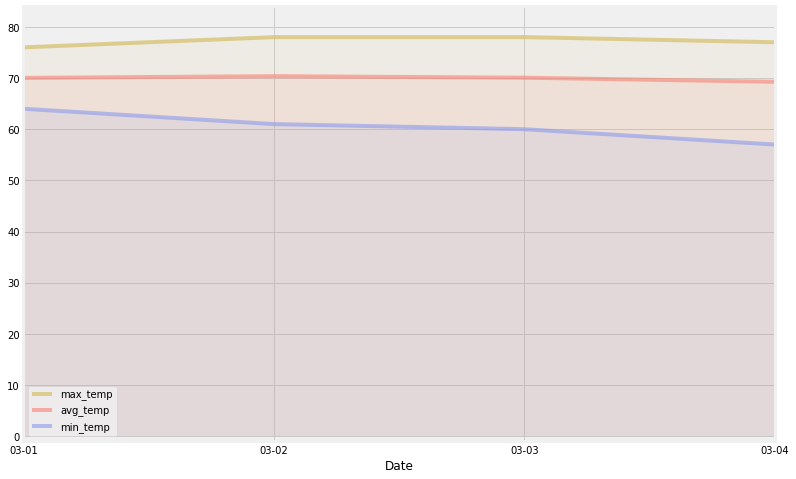

In [24]:
# Plot the daily normals as an area plot with `stacked=False`
fig, ax = plt.subplots(sharex=True,sharey=True)

date_index = transposed_df.index
temp_max = transposed_df['max_temp']
temp_avg = transposed_df['avg_temp']
tem_min = transposed_df['min_temp']

max_weather = ax.plot(
            date_index,
            temp_max,
            color='#d8c577',
            alpha=.8)

avg_weather = ax.plot(
            date_index,
            temp_avg,
            color='#fa8072',
            alpha=.6)

min_weather = ax.plot(
            date_index,
            tem_min,
            color='#8b9aed',
            alpha=.6)



fig.set_size_inches(12,8)
# -1 to show the bottom grid line
ax.fill_between(date_index,temp_max,facecolor='#d8c577',alpha=0.1)
ax.fill_between(date_index,temp_avg,facecolor='#fa8072',alpha=0.1)
ax.fill_between(date_index,tem_min,facecolor='#8b9aed',alpha=0.1)
ax.set_ylim(ymin=-1)
ax.set_xlim(left=1,right=4)
plt.legend()
plt.xlabel('Date')
plt.show();